## Embedding Projection for Higher Modality(T-SNE, PCA, Umap)
+ In this notebook we use different projection for the last layer prior to the softmax layer in the CNN-

## 1. Importing Libraries

In [2]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from utils.FeatureExtractor import get_vector_representation
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass
# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# 4. Wandb Tracker Experiements
import wandb

In [4]:
DATA_PATH = '../data/higher_modality_vol1.csv'
BASE_PATH = Path('/mnt')
BASE_IMG_DIR = BASE_PATH / 'subfigure-classification'
SEED = 42
model_path = '/mnt/artifacts/models/Higher_Modality/higher_modality_v1.pt'

## 2. Feature Extraction - ResNet CNN

## 2.1 Higher - Modality

In [5]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder,dict_label = label_encoder_target(df,target_col='higher_modality')
df.head()

,img,modality,set,source,img_path,higher_modality,caption,split_set
0,11373_2007_9226_Fig1_HTML-10.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-10.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
1,11373_2007_9226_Fig1_HTML-11.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-11.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
2,11373_2007_9226_Fig1_HTML-12.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-12.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
3,11373_2007_9226_Fig1_HTML-13.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-13.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
4,11373_2007_9226_Fig1_HTML-14.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-14.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN


In [8]:
# 3.1 Load the Resnet Model
model = ResNetClass.load_from_checkpoint(model_path)
print('*'*5,' Resnet Model Parameters ','*'*5)
print(model.hparams)
print('*'*5,' Resnet Model Children ','*'*5)
children_counter = 0
for n,c in model.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

*****  Resnet Model Parameters  *****
"class_weights":   [4.38888889 0.52605967 0.72953294 3.14067278 0.56028369 2.51715686]
"fine_tuned_from": whole
"lr":              1e-05
"mean_dataset":    tensor([0.6420, 0.6370, 0.6353])
"metric_monitor":  val_avg_loss
"mode_scheduler":  min
"name":            resnet101
"num_classes":     6
"pretrained":      True
"std_dataset":     tensor([0.3706, 0.3698, 0.3734])
*****  Resnet Model Children  *****
Children Counter:  0  Layer Name:  model


### 2.2 Get Feature Vector of the last conv layer


In [9]:
# Get the Embedding Matrix
# 1. Tranformations Needed
transform = [transforms.ToPILImage(),
             transforms.Resize((224, 224)),
             transforms.ToTensor(),
             transforms.Normalize(resnet_model.hparams['mean_dataset'], resnet_model.hparams['std_dataset'])
            ]
transform = transforms.Compose(transform)
# 2. Train Dataloader
dm = ImageDataModule    ( batch_size  = 32,
                          label_encoder    = le_encoder,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [transform,transform,transform],
                          num_workers      = 72,
                          target_class_col ='split_set',
                          modality_col     ='higher_modality',
                          path_col         ='img_path',
                          shuffle_train    = False) # Not Shuffling Train
dm.prepare_data()
dm.setup()

# 3. Model
fe_model = model.feature_extraction()
train_dataloader = dm.train_dataloader()
fe_matrix        = get_vector_representation(train_dataloader,fe_model,'cuda')

In [6]:
df_fe        = pd.DataFrame(fe_matrix,columns = [f"fe_{i}" for i in range(2048)])
df_embedding = pd.concat([df[df['split_set']=='TRAIN'].reset_index(drop = True),df_fe],axis = 1)

## 3. Embedding Projection - ResNet CNN

### 3.1 UMAP

In [7]:
# Generating the Model for UMAP
reducer = umap.UMAP(random_state=SEED)
reducer.fit(fe_matrix)
embedding = reducer.transform(fe_matrix)
df_umap_train = pd.concat([df[df['split_set']=='TRAIN'].reset_index(drop = True),pd.DataFrame(embedding,columns = [f"umap_{i}" for i in range(2)])],axis = 1)

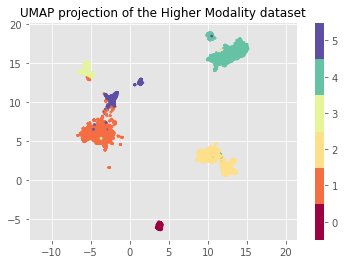

In [23]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=le_encoder.transform(df_embedding.higher_modality), cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(7)-0.5).set_ticks(np.arange(7))
plt.title('UMAP projection of the Higher Modality dataset', fontsize=12);

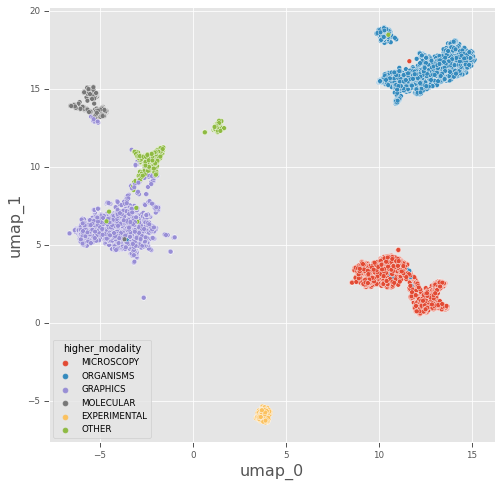

In [19]:
plt.figure(figsize=(8,8))
df1 = df_umap_train.reset_index(drop = True)
sns.scatterplot(data=df1, x="umap_0", y="umap_1", hue="higher_modality")
plt.show()

### 3.2 PCA

In [13]:
pca = PCA(n_components=2)
pca.fit(fe_matrix)
embedding = pca.transform(fe_matrix)
df_pca_train = pd.concat([df[df['split_set']=='TRAIN'].reset_index(drop = True),pd.DataFrame(embedding,columns = [f"pca_{i}" for i in range(2)])],axis = 1)

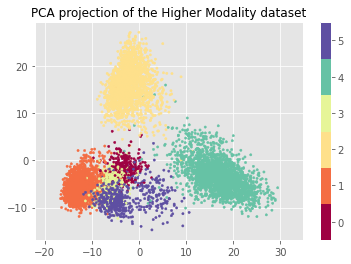

In [26]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=le_encoder.transform(df_embedding.higher_modality), cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(7)-0.5).set_ticks(np.arange(7))
plt.title('PCA projection of the Higher Modality dataset', fontsize=12);

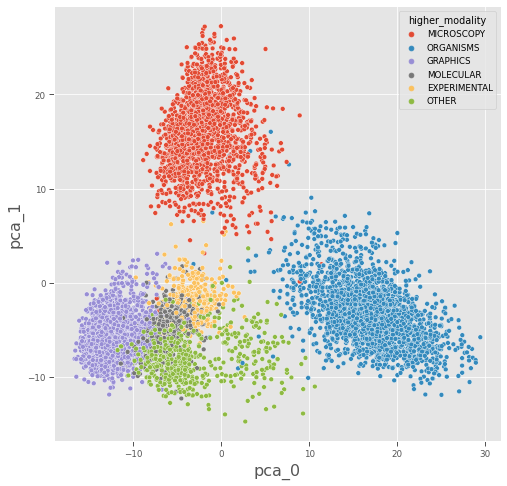

In [18]:
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16})   
plt.figure(figsize=(8,8))
df1 = df_pca_train.reset_index(drop = True)
sns.scatterplot(data=df1, x="pca_0", y="pca_1", hue="higher_modality")
plt.show()

### 3.3 T-SNE

In [20]:
%%time
model_tsne = TSNE(n_components=2, random_state=42,perplexity = 30)
embedding = model_tsne.fit_transform(fe_matrix)
df_tsne_train = pd.concat([df[df['split_set']=='TRAIN'].reset_index(drop = True),pd.DataFrame(embedding,columns = [f"TSNE_{i}" for i in range(2)])],axis = 1)

CPU times: user 57min 49s, sys: 1min 8s, total: 58min 58s
Wall time: 7min 56s


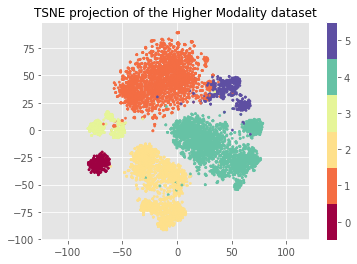

In [31]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=le_encoder.transform(df_embedding.higher_modality), cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(7)-0.5).set_ticks(np.arange(7))
plt.title('TSNE projection of the Higher Modality dataset', fontsize=12);

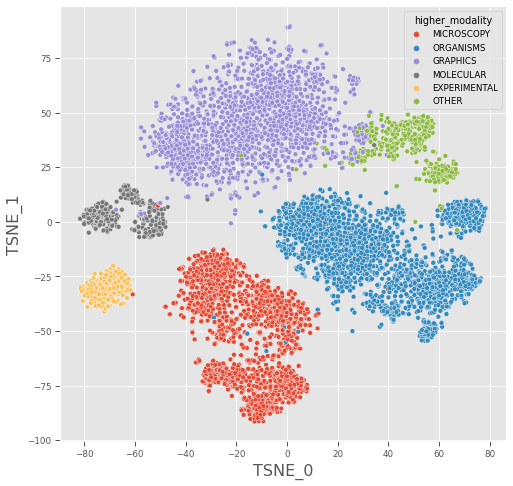

In [21]:
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16})   
plt.figure(figsize=(8,8))
df1 = df_tsne_train.reset_index(drop = True)
sns.scatterplot(data=df1, x="TSNE_0", y="TSNE_1", hue="higher_modality")
plt.show()